<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Reading-the-data-file-and-reviewing-general-information" data-toc-modified-id="Reading-the-data-file-and-reviewing-general-information-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Reading the data file and reviewing general information</a></span></li><li><span><a href="#Data-Preprocessing" data-toc-modified-id="Data-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Preprocessing</a></span></li><li><span><a href="#Test-Validity-Evaluation" data-toc-modified-id="Test-Validity-Evaluation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test Validity Evaluation</a></span><ul class="toc-item"><li><span><a href="#Test-Audience-Assessment" data-toc-modified-id="Test-Audience-Assessment-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Test Audience Assessment</a></span></li><li><span><a href="#Test-Period" data-toc-modified-id="Test-Period-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Test Period</a></span></li><li><span><a href="#Compliance-with-Test-Requirements" data-toc-modified-id="Compliance-with-Test-Requirements-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Compliance with Test Requirements</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span><ul class="toc-item"><li><span><a href="#Analysis-of-Event-Count-Distribution-per-User-in-the-Test-Groups" data-toc-modified-id="Analysis-of-Event-Count-Distribution-per-User-in-the-Test-Groups-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Analysis of Event Count Distribution per User in the Test Groups</a></span></li><li><span><a href="#Daily-Event-Distribution-Analysis-by-Group" data-toc-modified-id="Daily-Event-Distribution-Analysis-by-Group-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Daily Event Distribution Analysis by Group</a></span></li></ul></li><li><span><a href="#Funnel-Analysis" data-toc-modified-id="Funnel-Analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Funnel Analysis</a></span></li><li><span><a href="#Evaluation-of-A/B-Test-Results" data-toc-modified-id="Evaluation-of-A/B-Test-Results-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Evaluation of A/B Test Results</a></span><ul class="toc-item"><li><span><a href="#Testing-Statistical-Differences-in-User-Conversion-Rates-Between-Test-Groups" data-toc-modified-id="Testing-Statistical-Differences-in-User-Conversion-Rates-Between-Test-Groups-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Testing Statistical Differences in User Conversion Rates Between Test Groups</a></span></li></ul></li><li><span><a href="#General-Conclusions" data-toc-modified-id="General-Conclusions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>General Conclusions</a></span></li></ul></div>

# Project Description

**Objective**

The task is to evaluate the results of an A/B test conducted in accordance with the technical specification (TS). The goal is to assess the correctness of the test and its compliance with the TS.

**Technical Specification**

- Test name: `recommender_system_test`;
- Groups: A — control group, B — new payment funnel;
- Start date: 2020-12-07;
- User recruitment end date: 2020-12-21;
- Test end date: 2021-01-04;
- Audience: 15% of new users from the EU region must be selected for the test;
- Purpose: to test changes related to the implementation of an improved recommender system;
- Expected number of participants: 6,000;
- Expected outcome: Within 14 days from the registration date, users should demonstrate at least a 10% improvement in each of the following metrics:
  - Conversion to product page views — event `product_page`,
  - Additions to cart — `product_cart`,
  - Purchases — `purchase`.

**Data Description**

The data is presented in four datasets. The main dataset, `final_ab_events.csv`, contains the activity of new users from December 7, 2020, to January 4, 2021, and has the following structure:
- `user_id` — user identifier;
- `event_dt` — date and time of the event;
- `event_name` — event type;
- `details` — additional event information. For `purchase` events, this field stores the purchase amount in USD.

The dataset `final_ab_participants.csv` contains user group assignments and has the following structure:
- `user_id` — user identifier;
- `ab_test` — name of the test;
- `group` — user group.

Users registered from December 7 to December 21, 2020, are presented in the dataset `final_ab_new_users.csv`, which contains the following fields:
- `user_id` — user identifier;
- `first_date` — registration date;
- `region` — user's region;
- `device` — device used for registration.

Finally, the calendar of marketing events for 2020 is presented in the dataset `ab_project_marketing_events.csv` with the following structure:
- `name` — name of the marketing event;
- `regions` — regions where the campaign is conducted;
- `start_dt` — campaign start date;
- `finish_dt` — campaign end date.

**The project includes the following stages:**

- Data review and preprocessing;
- Evaluation of test validity (audience and test duration) and compliance with the TS;
- Exploratory data analysis, including event count per user and daily event trends;
- Construction of a funnel by test group;
- Evaluation of A/B test results and testing for statistical differences in conversion rates between funnel steps for the two groups;
- Final conclusions.

In [58]:
# Import necessary libraries for the project 
import pandas as pd
import scipy.stats as stats
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from statsmodels.stats.proportion import proportions_ztest

In [59]:
# Define variables for chart formatting
plt.style.use('seaborn-whitegrid')
sns.set_palette('Set2')
cmap = 'BuGn'
fontsize=13
figsize_w=(18,5)
figsize_n=(7,5)
figsize_norm=(10,6)
px_template = "simple_white"
px_palette = px.colors.qualitative.Set2

## Reading the data file and reviewing general information

In [60]:
# Loading the data
try:
    events, new_users, marketing, participants  = (pd.read_csv('final_ab_events.csv'),
                                        pd.read_csv('final_ab_new_users.csv'),
                                        pd.read_csv('ab_project_marketing_events.csv'),
                                        pd.read_csv('final_ab_participants.csv'))
except:
    display('File is not found')

Let's review general information about the `events` dataset.

In [61]:
display (events.head(3), events.info(), events.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99


None

,details
count,62740.000000
mean,23.877631
std,72.180465
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


In [62]:
display('Unique users: {}'.format(events['user_id'].nunique()), 
        'Date range: {} - {}'.format(events['event_dt'].min(), events['event_dt'].max()),
        'Unique event types: {}'.format(events['event_name'].unique()),
        'Unique event types with non-empty `details` field: {}'
        .format(events[~events['details'].isna()]['event_name'].unique()))

'Unique users: 58703'

'Date range: 2020-12-07 00:00:33 - 2020-12-30 23:36:33'

"Unique event types: ['purchase' 'product_cart' 'product_page' 'login']"

"Unique event types with non-empty `details` field: ['purchase']"

The `events` dataset contains data on 440,317 actions by 58,703 new users, recorded between December 7 and December 30, 2020.  
The `details` column may contain outliers, as there is a significant gap between the maximum value and the third quartile.  
Additionally, the `details` column includes missing values, which is expected because details are only provided for `purchase` events and represent the amount of the transaction.  
There are four unique event types: `purchase`, `product_cart`, `product_page`, and `login`.  
Column names do not contain stylistic or formatting errors.  
However, the `event_dt` column has an incorrect data type and needs to be converted.

Let’s review the general information about the `new_users` dataset.

In [63]:
display (new_users.head(), new_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


None

In [64]:
display ('Unique users: {}'.format(new_users['user_id'].nunique()), 
         'Time range: {} - {}'.format(new_users['first_date'].min(), new_users['first_date'].max()),
         'Unique regions: {}'.format(new_users['region'].unique()),
         'Unique devices: {}'.format(new_users['device'].unique()))

'Unique users: 61733'

'Time range: 2020-12-07 - 2020-12-23'

"Unique regions: ['EU' 'N.America' 'APAC' 'CIS']"

"Unique devices: ['PC' 'Android' 'iPhone' 'Mac']"

The `new_users` dataset contains records of 61,733 users who registered between December 7 and December 23, 2020.  
Each user is associated with one region (`EU`, `N.America`, `APAC`, `CIS`) and one device type (`PC`, `Android`, `iPhone`, `Mac`).  
There are no missing values. Column headers are formatted correctly.  
An incorrect data type is used for the `first_date` column.

Let's review the general information about the `marketing` dataset.

In [65]:
display (marketing.head(), marketing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


None

In [66]:
display ('Regions: {}'.format(marketing['regions'].unique()), 
         'Time period: {} - {}'.format(marketing['start_dt'].min(), marketing['finish_dt'].max()))

"Regions: ['EU, N.America' 'EU, CIS, APAC, N.America' 'N.America' 'APAC'\n 'EU, CIS, APAC' 'CIS']"

'Time period: 2020-01-25 - 2021-01-07'

The `marketing` dataset contains data on 14 marketing events conducted in the regions 'EU', 'N.America', 'APAC', and 'CIS' between January 25, 2020, and January 7, 2021.  
There are no missing values. Column headers are free of stylistic errors.  
Incorrect data types are used for the columns `start_dt` and `finish_dt`.

Let's review general information about the `participants` dataset.

In [67]:
display (participants.head(3), participants.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test


None

In [68]:
display('Unique users: {}'.format(participants['user_id'].nunique()),
        'Unique groups: {}'.format(participants['group'].unique()),
        'Unique A/B tests: {}'.format(participants['ab_test'].unique()))

'Unique users: 16666'

"Unique groups: ['A' 'B']"

"Unique A/B tests: ['recommender_system_test' 'interface_eu_test']"

The `participants` dataset contains data on 18,268 A/B test participants. However, there are only 16,666 unique users, which may indicate the presence of duplicates, overlap between groups within the same test, or overlap of users between two different tests.  
The dataset includes information on two tests: `recommender_system_test` and `interface_eu_test`. All participants are assigned to either group A or B.  
There are no missing values. Column headers are correctly formatted without stylistic issues.

**Summary**

The `events` dataset contains data on 440,317 actions performed by 58,703 new users during the period from December 7 to December 30, 2020. There are four unique event types: `purchase`, `product_cart`, `product_page`, and `login`.  
The `new_users` dataset includes records of 61,733 users who registered between December 7 and December 23, 2020. Each user is assigned one region (`EU`, `N.America`, `APAC`, `CIS`) and one device type (`PC`, `Android`, `iPhone`, `Mac`).  
The `marketing` dataset provides information on 14 marketing events conducted in the regions `EU`, `N.America`, `APAC`, and `CIS` between January 25, 2020 and January 7, 2021.  
The `participants` dataset contains data on 18,268 A/B test participants. However, only 16,666 of them are unique users, which may indicate duplicates, overlaps between groups within a single test, or overlaps across two different tests. The dataset includes two tests: `recommender_system_test` and `interface_eu_test`. All participants are assigned to either group A or B.

The `details` column in the `events` dataframe contains missing values, which is expected since it only stores information for the `purchase` event and reflects the purchase amount in dollars. There are no missing values in the other datasets.  
Column headers are correctly formatted without stylistic issues. However, incorrect data types are used for the following columns: `event_dt` in the `events` dataframe, `first_date` in `new_users`, and `start_dt` and `finish_dt` in `marketing`.

## Data Preprocessing

In [69]:
# Сonvert all columns containing user identifiers to lowercase
events['user_id'] = events['user_id'].apply(lambda x: x.lower())
new_users['user_id'] = new_users['user_id'].apply(lambda x: x.lower())
participants['user_id'] = participants['user_id'].apply(lambda x: x.lower())

In [70]:
# Check for obvious duplicates
display(events.duplicated().sum(), 
        new_users['user_id'].duplicated().sum(), 
        participants.duplicated().sum(), 
        marketing.duplicated().sum())

0

0

0

0

No explicit duplicates were found. The duplication of users in the `participants` dataset observed earlier will be examined when checking compliance with the technical specification.

In [71]:
# Convert columns with date and time data types
events['event_dt'] = pd.to_datetime(events['event_dt'])
new_users['first_date'] = pd.to_datetime(new_users['first_date']).dt.date
marketing['start_dt'] = pd.to_datetime(marketing['start_dt']).dt.date
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt']).dt.date

In [72]:
# Create an additional field in the events dataframe that stores only the event date
events['event_date'] = pd.to_datetime(events['event_dt']).dt.date

Check for anomalies in the 'details' field of the events `dataframe`:

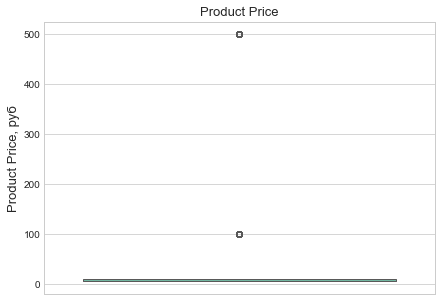

In [73]:
plt.figure(figsize=figsize_n)
ax=sns.boxplot(y='details', data=events)
plt.title('Product Price', fontsize=fontsize)
plt.ylabel('Product Price, руб', fontsize=fontsize)
plt.show()

In [74]:
display('Purchases over $50: {}'.format(events.query('details > 50')['details'].unique()),
        'Number of purchases over $50: {}'.format(events.query('details > 50')['details'].count()),
        '% of purchases equal to $99.99: {0:.2%}'.format(events.query('details == 99.99')['details'].count() /
                                                        events['details'].count()),
        '% of purchases equal to $499.99: {0:.2%}'.format(events.query('details == 499.99')['details'].count() /
                                                          events['details'].count()))

'Purchases over $50: [ 99.99 499.99]'

'Number of purchases over $50: 6848'

'% of purchases equal to $99.99: 8.98%'

'% of purchases equal to $499.99: 1.94%'

On the boxplot, two values—$99.99 and $499.99—stand out significantly. They account for 9% and 2% of all values in the 'details' column, respectively. Despite being outliers, these values should be retained as they do not appear to be accidental or single occurrences.

**Summary**

During preprocessing, no obvious duplicates were found. Data types for date and time fields were corrected. An additional column `event_date` was added to the `events` dataframe, containing only the date of the event without the time component.

## Test Validity Evaluation

### Test Audience Assessment

Let’s check for user overlaps between groups in the `recommender_system_test`.

In [75]:
participants.query('ab_test == "recommender_system_test"')['user_id'].duplicated().sum()

0

No overlaps were found between groups of the test under analysis. Now let’s check for overlaps between users in competing tests.

In [76]:
participants['user_id'].duplicated().sum()

1602

We found 1602 users who participated in both tests. The competing test 'interface_eu_test' also contains two groups: control (A) and test (B). The control group in the competing test sees the current version of the service—equivalent to group A of the test under analysis.

A problem arises if a user from group A of the competing test is also in group B of the analyzed test—it becomes unclear which version of the service the user actually experienced. Users from group B of the competing test are exposed to a modified version, which can skew the results of the test under analysis, regardless of whether the user is in group A or B.

Thus, when overlaps between competing tests exist, only users who were in group A of both tests should be retained. All others should be excluded.

In [77]:
users_to_drop = participants[participants['user_id'].duplicated(keep=False)].groupby('user_id')\
                                                    .agg({'group':'sum'}).query('group != "AA"').index.to_list()
len(users_to_drop)

1120

In [78]:
participants = participants.query('user_id not in @users_to_drop')

Next, we’ll add the test group information to the `new_users` and `events` dataframes. Users not participating in the test will be labeled as group 'N'.

In [79]:
participants_rec_sys = participants.query('ab_test == "recommender_system_test"')
new_users = new_users.merge(participants_rec_sys[['user_id', 'group']], on='user_id', how='left')
new_users['group'].fillna('N', inplace=True)
display('Duplicate users {}'.format(new_users['user_id'].duplicated().sum()))
new_users.groupby(['group']).agg({'user_id':'nunique'})

'Duplicate users 0'

,user_id
group,
A,3385
B,2196
N,56152


All users listed in `participants` as members of 'recommender_system_test' are present in `new_users`. No duplicates are found.
Let’s verify the group distribution by device type.

In [80]:
pivot = new_users.query('group != "N"')\
             .groupby(['group', 'device'])\
             .agg({'user_id':'nunique'})\
             .merge(new_users.groupby(['group', 'device'])\
                            .agg({'user_id':'nunique'}).reset_index(), 
                    on=['group', 'device'])\
             .merge(new_users.groupby(['group'])\
                            .agg({'user_id':'nunique'}), 
                    on='group').drop('user_id_y', axis=1)\
             .rename(columns={'user_id_x':'n_users', 'user_id':'all_users'})
pivot['%of users'] = round(pivot['n_users']/pivot['all_users']*100, 2)
pivot.sort_values('device')

,group,device,n_users,all_users,%of users
0,A,Android,1488,3385,43.96
4,B,Android,1026,2196,46.72
1,A,Mac,314,3385,9.28
5,B,Mac,185,2196,8.42
2,A,PC,883,3385,26.09
6,B,PC,527,2196,24.00
3,A,iPhone,700,3385,20.68
7,B,iPhone,458,2196,20.86


The user distribution across devices is balanced between groups.
Now let’s ensure all test participants generated events during the test period.

In [81]:
events = events.merge(participants_rec_sys[['user_id', 'group']], on='user_id', how='left')
events['group'].fillna('N', inplace=True)

In [82]:
pivot_users = events.groupby(['group']).agg({'user_id':'nunique'})\
                    .merge(new_users.groupby(['group']).agg({'user_id':'nunique'}), on='group')\
                    .rename(columns={'user_id_x':'users with events', 'user_id_y':'all users'})
pivot_users['% of users with events'] = round(pivot_users['users with events']/pivot_users['all users']*100, 2)
pivot_users

,users with events,all users,% of users with events
group,,,
A,2422,3385,71.55
B,706,2196,32.15
N,55575,56152,98.97


In [83]:
# Also, let’s verify the events fall within the test period
display('{} - {}'.format(events['event_date'].min(), events['event_date'].max()))

'2020-12-07 - 2020-12-30'

71.5% (2,422 users) of group A participants generated events during the test period.

Only 32% (706 users) from group B did so.

In contrast, 99% of new users not participating in the test generated events during the same period.

### Test Period

Let’s verify that the test period does not overlap with any marketing events.

In [84]:
start_date = pd.to_datetime('2020-12-07').date()
end_date = pd.to_datetime('2021-01-04').date()
marketing.query('(start_dt > @start_date & start_dt < @end_date) | (finish_dt > @start_date & finish_dt < @end_date)')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Two marketing campaigns overlapped with the test period — starting on December 25 and December 30 in different regions. Thus, the last 11 days of the 29-day test were affected. Let’s check how the campaigns influenced the event activity in groups A and B.

In [85]:
pivot_events = events.query('group != "N"').groupby(['group', 'event_date']).agg({'event_name':'count'})\
                     .reset_index().rename(columns={'event_date':'date', 'event_name':'n_events'})

In [86]:
fig = px.line(pivot_events, x='date', y='n_events', color='group', color_discrete_sequence=px_palette, 
              range_x=['2020-12-22', '2020-12-30'], range_y=[0, 1500])
fig.update_layout(title='Event Dynamics by Group',
                   xaxis_title='Date',
                  xaxis={'tickmode': 'linear'},
                   yaxis_title='Number of Events', template = px_template,
                   legend=dict(title='Group', y=1, xanchor="right"),
                   width=650,
                   height=400)
fig.add_shape(type='line',
              x0='2020-12-25', y0=0, x1='2020-12-25', y1=1500,
              line=dict(color='gray', width=2, dash='dash'),
              name='Start')
fig.add_annotation(x='2020-12-25', y=1000, text='Promo Start',
                   font=dict(size=12, color='gray'))
fig.show()

The graph shows no visible effect of the promotions on event dynamics for either group. Therefore, we can keep the data during this period.

### Compliance with Test Requirements

Let’s verify that the user onboarding dates match the technical specification (2020-12-07 to 2020-12-21):

In [87]:
display('Actual onboarding start date {}'.format(new_users.query('group != "N"')['first_date'].min()), 
        'Actual onboarding end date {}'.format(new_users.query('group != "N"')['first_date'].max()))

'Actual onboarding start date 2020-12-07'

'Actual onboarding end date 2020-12-21'

The actual onboarding dates fully match the expected period. According to the spec, the test duration should be from 2020-12-07 to 2021-01-04. Let’s check the actual test period:

In [88]:
#запомним фактические даты начала и окончания теста в переменные
start_date = events.query('group != "N"')['event_date'].min()
end_date = events.query('group != "N"')['event_date'].max()

display('Actual test start date {}'.format(start_date), 
        'Actual test end date {}'.format(end_date))

'Actual test start date 2020-12-07'

'Actual test end date 2020-12-30'

The test was stopped 5 days earlier than planned. Since we need to evaluate user metrics 14 days post-registration, early termination means some users may not have reached full lifetime. These users (even those who already converted) must be excluded to avoid biased results. Also, we exclude any events that occurred more than 14 days after registration.

In [89]:
# Define the new cutoff date for onboarding test participants
new_date = end_date - timedelta(days=14)
new_date

datetime.date(2020, 12, 16)

In [90]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
 4   event_date  440317 non-null  object        
 5   group       440317 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 20.2+ MB


In [91]:
# Merge the events and new_users dataframes and keep only events from test participants
events_ab = events.query('group != "N"')\
                  .merge(new_users.query('group != "N"')[['user_id', 'group', 'first_date','region']], 
                         on='user_id', how='right').drop(columns='group_x').rename(columns={'group_y': 'group'})

# Exclude users who registered after the new cutoff date for test participant onboarding
display('Excluded users: {}'.format(events_ab.query('first_date > @new_date')['user_id'].nunique()),
        'Excluded events: {}'.format(events_ab.query('first_date > @new_date')['user_id'].count()))
events_ab = events_ab.query('first_date <= @new_date')

# Convert columns to datetime
events_ab['event_date'] = pd.to_datetime(events_ab['event_date'])
events_ab['first_date'] = pd.to_datetime(events_ab['first_date'])

# Calculate the number of days from registration to event and exclude events 
# where this difference is greater than 14 days
events_ab['lft'] = (events_ab['event_date'] - events_ab['first_date']).dt.days
display('Excluded events: {}'.format(events_ab.query('lft > 14')['user_id'].count()))
events_ab = events_ab[(events_ab['event_name'].isna()) | (events_ab['lft'] <= 14)]


'Excluded users: 2000'

'Excluded events: 10056'

'Excluded events: 525'

During data preprocessing, 2,000 users who registered after December 16 and did not have time to show their two-week results before the test was stopped were excluded. Additionally, 10,056 events performed by such users and 525 events made by test participants more than 14 days after registration were removed.  

According to the technical specification, the expected number of test participants should be 6,000 users. Let's check how many users actually participated in the test and how they are distributed across the groups.

In [92]:
display(events_ab.query('group != "N"').groupby(['group']).agg({'user_id': 'nunique'}), 
        'Total number of test participants: {}'.format(events_ab['user_id'].nunique()))

,user_id
group,
A,2180
B,1401


'Total number of test participants: 3581'

In [93]:
display('Group A is larger than Group B by {:.2%}'.format((2180 - 1401) / 2180))

'Group A is larger than Group B by 35.73%'

After adjustment, 3,581 users participated in the test, which means the planned figure of 6,000 specified in the technical specification was not achieved. The distribution between the test groups is not even. The control group A (2,180 users) outnumbers group B (1,401 users) by 36%.  
Given the smaller size of group B, a 10% change in metrics will be noticeable only if the baseline conversion rate exceeds 44% ([Optimizely calculator](https://www.optimizely.com/sample-size-calculator)).  
According to the technical specification, the test should include 15% of new users from the EU region. Let's check the actual percentage. We will also assess the percentage of users from other regions present in the test groups.

In [94]:
display('Total new users from the EU region: {}'
        .format(new_users.query('region == "EU" & first_date <= @new_date')['user_id'].nunique()), 
        'Number of EU users included in the A/B test: {}'
        .format(events_ab.query('region == "EU"')['user_id'].nunique()),
        'Percentage of new EU users included in the A/B test: {:.2%}'
        .format(events_ab.query('region == "EU"')['user_id'].nunique()
                /new_users.query('region == "EU" & first_date <= @new_date')['user_id'].nunique()),
        'Percentage of users from other regions in group A: {:.2%}'
        .format(events_ab.query('region != "EU" & group == "A"')['user_id'].nunique()
                /events_ab['user_id'].nunique()),
        'Percentage of users from other regions in group B: {:.2%}'
        .format(events_ab.query('region != "EU" & group == "B"')['user_id'].nunique()
                /events_ab['user_id'].nunique()))

'Total new users from the EU region: 26986'

'Number of EU users included in the A/B test: 3353'

'Percentage of new EU users included in the A/B test: 12.42%'

'Percentage of users from other regions in group A: 3.32%'

'Percentage of users from other regions in group B: 3.04%'

The required proportion of EU users was not met. The test included 12.4% (3,353) of new EU users instead of the required 15%.
Although the test was intended to include only users from the EU region, approximately 3% of participants were from other regions. Since this share is relatively small and evenly distributed across groups, we can keep this data in the current form.

**Conclusions**

No overlaps were found between the groups of the analyzed test. However, 1,120 users were excluded from the data due to participation in competing tests (overlaps within control groups were retained). Not all users selected for the test generated events during the testing period.  
71.5% (2,422 users) of group A participants and only 32% (706 users) of group B participants performed events during the test. Meanwhile, almost all (99%) new users who were not part of the test generated events during the same period.

Two marketing campaigns overlapped with the test period. However, since these promotions did not affect the event dynamics in either group, events on the overlapping dates were retained.

The actual and planned user acquisition dates matched (2020-12-07 to 2020-12-21), but the test was stopped 5 days earlier than scheduled (on 2020-12-30). Therefore, to ensure the full 14-day user lifetime, 2,000 users who registered after December 16 and did not have time to demonstrate their two-week behavior before the test ended were excluded from the analysis. Events that occurred more than 14 days after registration were also excluded.

After adjustments, the test included 3,581 users instead of the target 6,000 — meaning the target set in the technical specification was not reached. The distribution between the test groups was uneven: the control group A (2,180 users) exceeded group B (1,401 users) by 36%.  
Considering the smaller size of group B, a 10% change will only be statistically significant if the baseline conversion is above 44% ([Optimizely calculator](https://www.optimizely.com/sample-size-calculator)).

The required share of EU-region users was also not met. The test included 12.4% (3,353) new users from the EU, instead of the expected 15%. Although the test was meant to include only EU users, approximately 3% of participants were from other regions. Since this share is small and evenly distributed across groups, the data can be kept as is.

## Exploratory Data Analysis

### Analysis of Event Count Distribution per User in the Test Groups

We'll create a pivot table that counts the number of events per user, taking into account their assigned test group, and plot histograms of the distribution.

In [95]:
pivot_events = events_ab.groupby(['user_id', 'group']).agg({'event_name':'count'}).reset_index()
# Examine the distribution of event counts per user
pivot_events['event_name'].describe()

count    3581.000000
mean        3.129293
std         4.236155
min         0.000000
25%         0.000000
50%         0.000000
75%         6.000000
max        24.000000
Name: event_name, dtype: float64

In [96]:
# Plot the histogram
fig = px.histogram(pivot_events, x='event_name', color='group', histnorm="percent",
                   nbins=25, barmode='group', color_discrete_sequence=px_palette) 

fig.update_layout(title='Distribution of Event Count per User by Group',
                  xaxis_title='Number of Events',
                  xaxis={'tickmode': 'linear'},
                   yaxis_title='Frequency, %', template = px_template,
                   legend=dict(title='Group', y=1, xanchor="right"),
                   width=650,
                   height=400)
fig.show()

Each user performed between 0 and 24 events.
There are significantly more users in group B (65.6%) who performed no events compared to group A (44%). This may indicate an imbalance in traffic distribution during user recruitment.
The frequency distribution is uneven — both groups show dips at certain event counts (e.g., 1, 5, 7).

Now let's calculate the average number of events per user, including those who performed no events:

In [97]:
events_ab.groupby(['user_id', 'group']).agg({'event_dt':'count'}).groupby('group').agg({'event_dt':'mean'})\
         .apply(lambda x: round(x, 2)).rename(columns={'event_dt':'events_per_user'})

,events_per_user
group,
A,3.87
B,1.98


And then calculate the average number of events per user, excluding users who performed no events:

In [98]:
events_ab.groupby(['user_id', 'group']).agg({'event_dt':'count'}).query('event_dt > 0')\
         .groupby('group').agg({'event_dt':'mean'}).apply(lambda x: round(x, 2))\
         .rename(columns={'event_dt':'events_per_user'})

,events_per_user
group,
A,6.93
B,5.75


On average, users in group A perform more events than users in group B, both when including and excluding users with zero events.

### Daily Event Distribution Analysis by Group

Let’s analyze how the daily number of events changed across the two groups.

In [99]:
# Aggregate number of events by day and group
pivot_events = events_ab.groupby(['group', 'event_date']).agg({'event_dt':'count'}).reset_index()

In [100]:
# Plot the daily event dynamics
fig = px.line(pivot_events, x='event_date', y='event_dt', color='group', color_discrete_sequence=px_palette)
fig.update_layout(title='Daily Event Dynamics by Group',
                  xaxis_title='Day (December 2020)',
                  yaxis_title='Number of Events',
                  xaxis=dict(tickformat='%d', tickmode='linear'),
                  template=px_template,
                  legend=dict(title='Group', y=1, xanchor="right"),
                  width=650,
                  height=400)

# Add vertical line for participant recruitment cutoff
fig.add_shape(type='line',
              x0='2020-12-16', y0=0, x1='2020-12-16', y1=1100,
              line=dict(color='gray', width=2, dash='dash'))
fig.add_annotation(x='2020-12-16', y=1100, text='End of User Recruitment',
                   font=dict(size=12, color='gray'))
fig.show()

In group A, the daily number of events ranged between 270–290 from December 7 to 13, but from December 14 to 16 there was a sharp increase to 930–970.
Group B showed no such spikes; its event count stayed between 115–290 during the same period.
After December 16, a gradual decline is observed in both groups, corresponding to the end of user recruitment.

Let’s check whether the spike in group A events is linked to the users recruited on those dates:

In [101]:
# Aggregate number of events by users’ registration date and group
pivot_events = events_ab.groupby(['group', 'first_date']).agg({'event_dt':'count'}).reset_index()

In [102]:
fig = px.line(pivot_events, x='first_date', y='event_dt', color='group', color_discrete_sequence=px_palette)
fig.update_layout(title='Number of Events per Registration Date by Group',
                  xaxis_title='Day (December 2020)',
                  yaxis_title='Number of Events',
                  xaxis=dict(tickformat='%d', tickmode='linear'),
                  template=px_template,
                  legend=dict(title='Group', y=1, xanchor="right"),
                  width=650,
                  height=400)
fig.show()

Participants recruited into group A on December 14, 15, and 16 performed 12, 6.4, and 5 times more events, respectively, than users recruited on December 13.
Group B does not show such spikes, although overall event activity in group B is consistently lower than in group A.

Now let’s check whether user recruitment was balanced over time:

In [103]:
# Aggregate daily unique recruited users by group
pivot_events = events_ab.groupby(['group', 'first_date']).agg({'user_id':'nunique'}).reset_index()

In [104]:
pivot_events = events_ab.groupby(['group', 'first_date']).agg({'user_id': 'nunique'}).reset_index()
fig = px.line(pivot_events, x='first_date', y='user_id', color='group', color_discrete_sequence=px_palette)
fig.update_layout(title='Number of Recruited Users per Day by Group',
                  xaxis_title='Day (December 2020)',
                  yaxis_title='Number of Users',
                  xaxis=dict(tickformat='%d', tickmode='linear'),
                  template=px_template,
                  legend=dict(title='Group', y=1, xanchor="right"),
                  width=650,
                  height=400)
fig.show()

User recruitment was not uniform. Peaks are seen on December 7, 10, and 12–14, with synchronized recruitment “waves” in both groups.
However, only group A shows a spike in event activity on December 14, which strongly suggests imbalances in traffic allocation.

**Conclusion**

The exploratory analysis reveals the following:

- The share of users with no events is significantly higher in group B (65.6%) than in group A (44%).

- Participants in group A recruited on December 14, 15, and 16 performed 12, 6.4, and 5 times more events, respectively, than those recruited on December 13 — causing a 3.2–3.6x increase in daily averages.No such behavior is observed in group B, despite the synchronized recruitment pattern across both groups.

These findings suggest potential traffic allocation issues during the experiment, which may negatively impact test validity.

## Funnel Analysis

Let’s build event funnels for both test groups.

In [106]:
def calc_funnel(data_funnel):
    '''
    The function takes a dataframe `data_funnel` as input and builds a summary table `funnel`
    containing the number of unique users who triggered each event in the 'event_name' column.
    Then, it adds a new event 'registration' to account for all unique users from 'user_id'.
    The function returns the funnel dataframe.
    '''
    funnel = data_funnel.groupby('event_name').agg({'user_id':'nunique'})\
                     .rename(columns=({'event_name':'event', 'user_id':'n_users'}))\
                     .sort_values('n_users', ascending = False).reset_index()
    registration = pd.DataFrame({'event_name': ['registration'], 'n_users': [data_funnel['user_id'].nunique()]})
    funnel = pd.concat([funnel, registration]).sort_values('n_users', ascending = False)\
                                              .reset_index().drop(columns='index')
    return(funnel.sort_values('n_users', ascending = False))

In [107]:
data_funnel_A = events_ab.query('group == "A"')[['user_id', 'group', 'event_name']].drop_duplicates()
data_funnel_B = events_ab.query('group == "B"')[['user_id', 'group', 'event_name']].drop_duplicates()
funnel_A = calc_funnel(data_funnel_A)
funnel_B = calc_funnel(data_funnel_B)
display('Group A:', funnel_A, 'Group B', funnel_B)

'Group A:'

,event_name,n_users
0,registration,2180
1,login,1217
2,product_page,774
3,purchase,366
4,product_cart,365


'Group B'

,event_name,n_users
0,registration,1401
1,login,481
2,product_page,273
3,product_cart,133
4,purchase,129


Users typically go through four events (in sequence):

- Registration (registration)
- Login (login)
- Product page view (product_page)
- Purchase (purchase)

These steps will be used for funnel calculation.

There is also a 'product_cart' event (viewing the shopping cart), but since fewer users trigger this event than make purchases in Group A, it is not considered a required funnel step (one-click purchase is possible).

Let’s visualize the funnels:

In [109]:
# Set the correct step order
steps = funnel_B.query('event_name != "product_cart"')['event_name'].to_list()

# Build funnel plots
fig1 = go.Figure(go.Funnel(y=steps, x=funnel_A.query('event_name != "product_cart"')['n_users'].to_list(),
                           name='Group A', textinfo="value+percent initial", marker={"color": px_palette[0]}))
fig2 = go.Figure(go.Funnel(y=steps, x=funnel_B.query('event_name != "product_cart"')['n_users'].to_list(),
                           name='Group B', textinfo="value+percent initial", marker={"color": px_palette[1]}))

fig = make_subplots(rows=1, cols=2)
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)
fig.update_layout(legend=dict(y=0, xanchor="right"), template=px_template,
                  width=980, height=400, title='Event Funnels for A/B Test Groups')
fig.show()

As noted earlier, significantly more users in Group A triggered at least one event compared to Group B, resulting in initial step conversion rates of 34% and 56%, respectively.
64% of logged-in Group A users and 57% of Group B users viewed a product page. Of those, only 47% made a purchase in both groups.
Ultimately, 17% of Group A and 9% of Group B users completed the full funnel from registration to purchase.

Let’s also look at the conversion to the non-required 'product_cart' event:

In [111]:
display ('Conversion to `product_cart` for Group A: {0:.2%}'
         .format(funnel_A.query('event_name == "product_cart"')['n_users'][4]/data_funnel_A['user_id'].nunique()),
         'Conversion to `product_cart` for Group B: {0:.2%}'
         .format(funnel_B.query('event_name == "product_cart"')['n_users'][3]/data_funnel_B['user_id'].nunique()))


'Conversion to `product_cart` for Group A: 16.74%'

'Conversion to `product_cart` for Group B: 9.49%'

Group B’s performance is concerning. To further investigate the impact of traffic imbalance on Group B’s results, let’s build funnels for users who registered before December 14:

In [112]:
# Exclude users who registered after Dec 13
date_corr = pd.to_datetime('2020-12-14').date()
events_ab_corr = events_ab.query('first_date < @date_corr')

# Calculate funnels
data_funnel_A_corr = events_ab_corr.query('group == "A"')[['user_id', 'group', 'event_name']].drop_duplicates()
data_funnel_B_corr = events_ab_corr.query('group == "B"')[['user_id', 'group', 'event_name']].drop_duplicates()
funnel_A_corr = calc_funnel(data_funnel_A_corr)
funnel_B_corr = calc_funnel(data_funnel_B_corr)
display('Group A:', funnel_A_corr, 'Group B', funnel_B_corr)

'Group A:'

,event_name,n_users
0,registration,1504
1,login,541
2,product_page,327
3,purchase,136
4,product_cart,135


'Group B'

,event_name,n_users
0,registration,994
1,login,324
2,product_page,180
3,purchase,88
4,product_cart,80


In [113]:
# Set step order
steps = funnel_B_corr.query('event_name != "product_cart"')['event_name'].to_list()

# Funnel plots
fig1 = go.Figure(go.Funnel(y=steps, x=funnel_A_corr.query('event_name != "product_cart"')['n_users'].to_list(),
                           name='Group A', textinfo="value+percent initial", marker={"color": px_palette[0]}))
fig2 = go.Figure(go.Funnel(y=steps, x=funnel_B_corr.query('event_name != "product_cart"')['n_users'].to_list(),
                           name='Group B', textinfo="value+percent initial", marker={"color": px_palette[1]}))

fig = make_subplots(rows=1, cols=2)
fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)
fig.update_layout(legend=dict(y=0, xanchor="right"), template=px_template,
                  width=980, height=400, title='Event Funnels for A/B Groups (Cleaned Data)')
fig.show()

In [115]:
display ('Conversion to `product_cart` for Group A: {0:.2%}'
         .format(funnel_A_corr.query('event_name == "product_cart"')['n_users'][4]/data_funnel_A_corr['user_id'].nunique()),
         'Conversion to `product_cart` for Group B: {0:.2%}'
         .format(funnel_B_corr.query('event_name == "product_cart"')['n_users'][4]/data_funnel_B_corr['user_id'].nunique()))


'Conversion to `product_cart` for Group A: 8.98%'

'Conversion to `product_cart` for Group B: 8.05%'

The cleaned dataset is smaller, but even here the conversion rates show no improvement. Group A still outperforms Group B in all key steps (product_cart, product_page, and purchase), albeit with smaller differences.
The reduced conversion gap for the login step suggests that the imbalance was caused by "anomalous" users who have now been excluded.

**Conclusion**

The funnel consists of 4 main events:

- registration
- login
- product_page
- purchase

The product_cart event stands out as a non-mandatory step in the funnel (indicating one-click purchases are possible). The conversion to this step was 16.7% and 9.5% for Groups A and B, respectively.

As mentioned earlier, significantly more users in Group A triggered at least one event compared to Group B, which explains the initial step conversion rates of 34% and 56%, respectively. The product page was viewed by 64% and 57% of logged-in users in Groups A and B, respectively. Of those, only 47% proceeded to make a purchase. As a result, 17% of Group A users and 9% of Group B users completed the entire journey from registration to payment.

Group B consistently shows lower conversion rates than Group A across all funnel stages, including the optional product_cart step.

After excluding users who registered after December 13 (where traffic distribution anomalies were observed), conversion rates to product_cart, product_page, and purchase remained higher for Group A, though with a narrower gap.

## Evaluation of A/B Test Results

### Testing Statistical Differences in User Conversion Rates Between Test Groups

We will assess the statistical significance of differences in proportions between the test groups.
Let us formulate the hypotheses:
```
H₀ (null hypothesis): The share of users in Group 1 who performed the event equals the share of users in Group 2 who performed the event.

H₁ (alternative hypothesis): The share of users in Group 1 who performed the event does not equal the share of users in Group 2 who performed the event.

```
We need to define the significance level (alpha). Since we are performing multiple comparisons, we need to adjust for the family-wise error rate. We'll use the Bonferroni correction for this purpose. The number of planned comparisons is 4 (the number of funnel steps).

In [116]:
# Set significance level and number of tests
alpha = 0.05
# Apply Bonferroni correction
alpha_bonf = alpha / 4

In [120]:
# Perform hypothesis testing for each funnel step
for i in range(1, funnel_A['event_name'].nunique()):
    successes = np.array([funnel_A['n_users'][i], funnel_B['n_users'][i]])
    samples = np.array([funnel_A['n_users'][0], funnel_B['n_users'][0]])
    z_stat, p_value = proportions_ztest(successes, samples)

    display('Event: {}'.format(funnel_A['event_name'][i]))
    if p_value < alpha_bonf:
        display(
            'p-value: {}: Reject the null hypothesis — there is a statistically significant difference in proportions.'
            .format(p_value))
    else:
        display(
            'p-value: {}: Failed to reject the null hypothesis — no evidence of a significant difference in proportions.'
            .format(p_value))
    display('--------------------------------------------------------------------------------------------------')

'Event: login'

'p-value: 3.0662679606265606e-36: Reject the null hypothesis — there is a statistically significant difference in proportions.'

'--------------------------------------------------------------------------------------------------'

'Event: product_page'

'p-value: 8.253388233854424e-25: Reject the null hypothesis — there is a statistically significant difference in proportions.'

'--------------------------------------------------------------------------------------------------'

'Event: purchase'

'p-value: 7.625394980755871e-10: Reject the null hypothesis — there is a statistically significant difference in proportions.'

'--------------------------------------------------------------------------------------------------'

'Event: product_cart'

'p-value: 1.7533097084186028e-10: Reject the null hypothesis — there is a statistically significant difference in proportions.'

'--------------------------------------------------------------------------------------------------'

The analysis showed statistically significant differences in all cases under comparison.
We can conclude that the change in the recommendation system has an impact on user behavior.

## General Conclusions

According to the technical specification, it was expected that within 14 days from registration, users in group B would show at least a 10% improvement in conversion rates for product page views (`product_page`), cart views (`product_cart`), and purchases (`purchase`).

However, the results showed that the test group underperformed the control group across all key metrics:
- by 16% in product page views (`product_page`),
- by 7.2% in cart views (`product_cart`),
- by 7.6% in purchases (`purchase`).  
A statistical significance check using the z-test confirmed that these differences are statistically significant.

Several issues were identified in the test execution, including:
- user overlap with a competing A/B test,
- overlap between the test period and marketing campaigns.

There were also deviations from the technical specification in the following areas:
- the test ended 5 days earlier than planned, resulting in ~2000 users being excluded to preserve the required 14-day lifetime window;
- after all adjustments, the test included 3,581 users, falling short of the planned 6,000;
- the group split was imbalanced: control group A (2,180 users) was 36% larger than test group B (1,401 users);
- with the given sample size for group B, a 10% effect would only be statistically detectable if baseline conversion exceeds 44% — which is true only for the `login` step;
- only 12.4% of users in the test were from the EU region instead of the required 15%, and ~3% were from other regions.

Traffic allocation during participant selection was also inconsistent, resulting in the following anomalies:
- the share of users who did not perform any actions was much higher in group B (65.6%) compared to group A (44%);
- users assigned to group A between December 14–16 performed 5–12 times more events than those added on December 13. This spike did not occur in group B, despite synchronized user intake.

All these issues negatively affect the test's reliability.  
However, even after excluding users selected during the problematic period, group A still outperforms group B on key metrics—albeit with smaller differences.

**Therefore, despite multiple execution flaws, we can conclude that the introduction of the new recommendation system does not improve user behavior (conversion through the funnel steps) and likely has a negative effect.**